In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

/Users/yuanp/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yuanp/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yuanp/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yuanp/miniconda3/lib/python3.7/site-packages/tensor

# 1. Import Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train["text"][15]

"What's up man?"

In [4]:
train[train["target"] == 0] ["text"].values[1]

'I love fruits'

# 2. Basic Pre-processing

### 2.1 Case Folding - Lower case the words

In [5]:
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

### 2.2 Removing Punctuation

In [6]:
train['text'] = train['text'].str.replace('[^\w\s]','')
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### 2.2.1 Removing Numerics

In [7]:
train['text'] = train['text'].apply(lambda x: ' '.join([x for x in x.split() if not x.isdigit()]))
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    people receive wildfires evacuation orders in ...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### 2.3 Removal of Stop Words

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [9]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(('pt','tbk','laporan','report','company','ii','i','perusahaan','p','perseroan','jl','indonesia','persero'))

train['text'] = train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

### 2.4 Import Tensorflow

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

### 2.5 Counting The Number of Words

In [11]:
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [12]:
text_values = train["text"]

counter = counter_word(text_values)

### 2.6 Defining Constants for Classification

In [13]:
vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each tweet.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

### 2.7 Splitting Train-Test Data

In [14]:
training_sentences = np.asarray(train.text[0:training_size])
training_labels = np.asarray (train.target[0:training_size])

testing_sentences = np.asarray(train.text[training_size:])
testing_labels = np.asarray(train.target[training_size:])

### 2.8 Tokenizing Input, Sequencing, and Padding

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

In [16]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# 3. Classifier Model - LSTM Binary Classifier

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # for a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
num_epochs = 10
history = model.fit(training_padded,training_labels,epochs=num_epochs, 
                    validation_data =(testing_padded, testing_labels))

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.5558 - accuracy: 0.7057 - val_loss: 0.5229 - val_accuracy: 0.7518
Epoch 2/10
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.2799 - accuracy: 0.8929 - val_loss: 0.4870 - val_accuracy: 0.7682
Epoch 3/10
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.1297 - accuracy: 0.9560 - val_loss: 0.6354 - val_accuracy: 0.7643
Epoch 4/10
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.0703 - accuracy: 0.9760 - val_loss: 0.7259 - val_accuracy: 0.7630
Epoch 5/10
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.0477 - accuracy: 0.9852 - val_loss: 0.7074 - val_accuracy: 0.7754
Epoch 6/10
6090/6090 [==============================] - 9s 2ms/sample - loss: 0.0376 - accuracy: 0.9901 - val_loss: 0.8196 - val_accuracy: 0.7603
Epoch 7/10
6090/6090 [==============================] - 9s 2ms/sample - lo

In [19]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.555825,0.705747,0.522896,0.751806
1,0.279891,0.892939,0.487006,0.768221
2,0.129698,0.955993,0.635439,0.764281
3,0.070325,0.976026,0.725919,0.762968
4,0.047664,0.985222,0.707398,0.775443


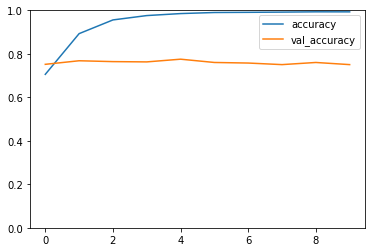

In [20]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1])